In [3]:
#adapted from https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical 
from keras import applications, optimizers
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report

In [47]:
#set target size for resizing all images 
img_width, img_height = 224, 224

#directory paths for training data, validation data, test data, and weight file
train_dir = 'xray/data/train'
val_dir = 'xray/data/val'
test_dir = 'xray/data/test_set'
top_model_weights_dir = 'xray/bottleneck_transfer_model_xray.h5'

#number of epochs (one run of the entire dataset through the NN) 
#and batch size (how many images are in each batch the dataset is split into)
epochs = 50
batch_size = 20
    
#save the features discovered by running a pretrained VGG16 architecture on our data

    
#create data augmentations for training set; helps reduce overfitting and find more features
train_datagen = ImageDataGenerator(rescale=1./255,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip=True)
    
#use ImageDataGenerator to upload validation images; data augmentation not necessary for validating process
val_datagen = ImageDataGenerator(rescale=1./255)
    
#load VGG16 model, pretrained on imagenet database
model = applications.VGG16(include_top=False, weights='imagenet')
    
#generator to load images into NN
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)

#total number of images used for training data
num_train = len(train_generator.filenames)
    
#save features to numpy array file so features do not overload memory
bottleneck_features_train = model.predict_generator(train_generator, num_train // batch_size)

val_generator = val_datagen.flow_from_directory(
            val_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    
num_val = len(val_generator.filenames)
    
bottleneck_features_validation = model.predict_generator(val_generator, num_val // batch_size)

Found 3600 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


In [116]:
def train_top_model():
    #used to retrieve the labels of the images
    label_datagen = ImageDataGenerator(rescale=1./255)
    
    #generators can create class labels for each image in either 
    train_label_generator = label_datagen.flow_from_directory(  
        train_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)  
    
    #total number of images used for training data
    num_train = len(train_label_generator.filenames)
    num_classes = len(train_label_generator.class_indices) 
    #load features from VGG16 and pair each image with corresponding label
    #train_data = np.load('xray/bottleneck_features_train.npy')
    #get the class labels generated by train_label_generator 
    train_labels = train_label_generator.classes
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    
    val_label_generator = label_datagen.flow_from_directory(  
        val_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)
    
    num_val = len(val_label_generator.filenames)

    #val_data = np.load('xray/bottleneck_features_validation.npy')
    val_labels = val_label_generator.classes
    val_labels = to_categorical(val_labels, num_classes=num_classes)
    #create fully connected layers, replacing the ones cut off from the VGG16 model
    model = Sequential()
    #converts model's expected input dimensions to same shape as bottleneck feature arrays 
    model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
    #ignores a fraction of input neurons so they do not become co-dependent on each other; helps prevent overfitting
    model.add(Dropout(0.7))
    #normal fully-connected layer with relu activation. Replaces all negative inputs with 0 and does not fire neuron,
    #creating a lighter network
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    #output layer to classify 0 or 1
    model.add(Dense(num_classes, activation='sigmoid'))
    
    print(model.summary())
    
    #compile model and specify which optimizer and loss function to use
    #optimizer used to update the weights to optimal values; adam optimizer maintains seperate learning rates
    #for each weight and updates accordingly
    
    #cross-entropy function measures the ability of model to correctly classify class
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    #used to stop training if NN shows no improvement for 5 epochs
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1)
    
    #checks each epoch as it runs and saves the weight file from the model with the lowest validation loss
    checkpointer = ModelCheckpoint(filepath=top_model_weights_dir, verbose=1, save_best_only=True)

    #fit the model to the data
    history = model.fit(bottleneck_features_train, train_labels,
            epochs=epochs,
            batch_size=batch_size,
            callbacks = [early_stop, checkpointer],
            verbose=2,
            validation_data=(bottleneck_features_validation, val_labels))
    
    #evaluate how well model predicts the data
    (eval_loss, eval_accuracy) = model.evaluate(bottleneck_features_validation, val_labels, batch_size=batch_size, verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
    print("[INFO] Loss: {}".format(eval_loss))
    
    plt.figure(figsize=(8, 6)),
    plt.ylim(0.2,1)
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'val'], loc='lower right')  

Found 3600 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_54 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 25088)             0         
_________________________________________________________________
dense_107 (Dense)            (None, 256)               6422784   
_________________________________________________________________
dropout_108 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 3)                 771       
Total params: 6,423,555
Trainable params: 6,423,555
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600 samples, validate on 360 sampl

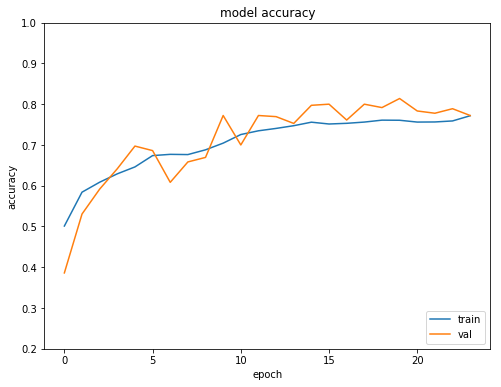

In [117]:
#calls to functions needed to build NN
train_top_model()

In [110]:
#load test images into array for testing model predictions
all_images = []
for sub in sorted(os.listdir(test_dir)):
    for image_path in os.listdir(test_dir + '/' + sub):
        image = load_img(test_dir + '/' + sub + '/' + image_path, target_size=(img_width, img_height))
        image = img_to_array(image)
        all_images.append(image)
all_val = np.array(all_images)

#must divide image array by 255 due to 'rescale=1./255' in ImageDataGenerator; rescales all image values from
#[0-255] range to [0-1.0] range
all_val = all_val / 255

In [119]:
#generate a label array; create a generator to retrieve the labels of the test images
test_label_datagen = ImageDataGenerator(rescale=1./255)
    
test_label_generator = test_label_datagen.flow_from_directory(  
    test_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  

test_labels = test_label_generator.classes
num_classes = len(test_label_generator.class_indices)  

#build the same architecture as the one trained previously; test images need to go through the same pipeline
#in order to work with the model
model = applications.VGG16(include_top=False, weights='imagenet')

bottleneck_prediction = model.predict(all_val) 

model = Sequential()  
model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))  
model.add(Dropout(0.7))
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.7))  
model.add(Dense(num_classes, activation='sigmoid')) 

#load the optimal weights that were saved during training
model.load_weights(top_model_weights_dir) 

#generate a class prediction array; 0 or 1 for every image in the test image set
all_pred_class = model.predict_classes(bottleneck_prediction, verbose=0)
#generate a prediction array; probability values of each image being of class 1 for every image in test image set
all_pred = model.predict(bottleneck_prediction, verbose=0)

#geneate false postive rate and true positive rate
#fpr, tpr, thresholds = roc_curve(test_labels, all_pred)
#calculate area under curve for the ROC curve
#roc_auc = auc(fpr, tpr)

print(confusion_matrix(test_labels, all_pred_class))
print(classification_report(test_labels, all_pred_class))

Found 623 images belonging to 3 classes.
[[203  29  10]
 [  1 223   9]
 [ 11  10 127]]
             precision    recall  f1-score   support

          0       0.94      0.84      0.89       242
          1       0.85      0.96      0.90       233
          2       0.87      0.86      0.86       148

avg / total       0.89      0.89      0.89       623

